# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 9

        self.convblock8 =nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) #output 7
        self.convblock9 =nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) #output 5
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
              ReLU-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
           Dropout-4            [-1, 6, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             432
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             720
             ReLU-10           [-1, 10, 28, 28]               0
      BatchNorm2d-11           [-1, 10, 28, 28]              20
          Dropout-12           [-1, 10, 28, 28]               0
           Conv2d-13           [-1, 10, 26, 26]             900
             ReLU-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.12442032247781754 Batch_id=468 Accuracy=92.83: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]



Test set: Average loss: 0.0449, Accuracy: 9858/10000 (98.58%)

EPOCH: 1


Loss=0.05273613706231117 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]



Test set: Average loss: 0.0331, Accuracy: 9888/10000 (98.88%)

EPOCH: 2


Loss=0.20034565031528473 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:23<00:00, 19.56it/s]



Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.042027007788419724 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:24<00:00, 19.51it/s]



Test set: Average loss: 0.0267, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.039713043719530106 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]



Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.04498488828539848 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]



Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.02135302685201168 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]



Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.10599980503320694 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:24<00:00, 19.41it/s]



Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.04812689498066902 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]



Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.012756425887346268 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]



Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.014522644691169262 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]



Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.07383915036916733 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]



Test set: Average loss: 0.0187, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.04174979403614998 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.0659441277384758 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.1815400868654251 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s]



Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.0019491385901346803 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]



Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.0030007583554834127 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]



Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.03758471831679344 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]



Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.010413543321192265 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]



Test set: Average loss: 0.0194, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.026832913979887962 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]



Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

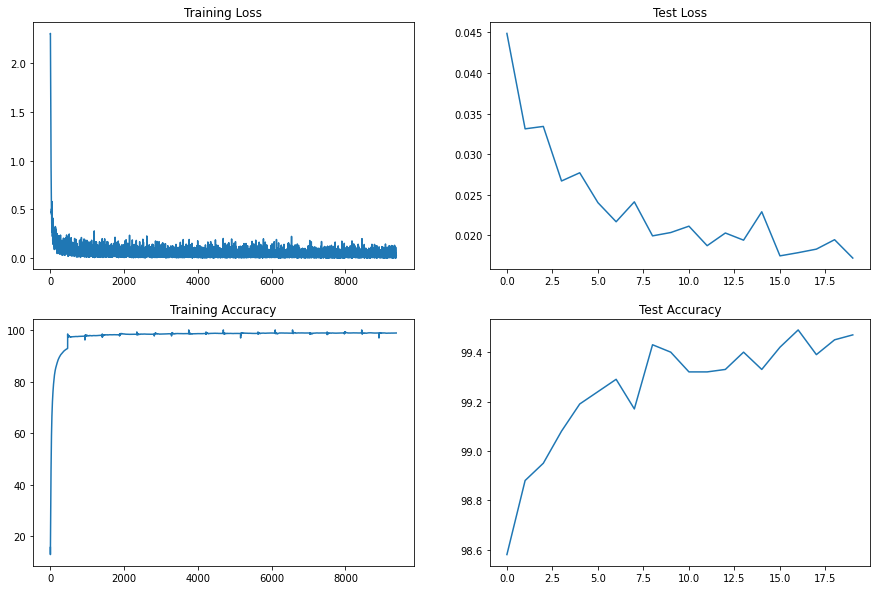

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")